In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [251]:
z1 = torch.tensor([0,1], dtype=torch.float32)
z2 = torch.tensor([0,0], dtype=torch.float32)
z3 = torch.tensor([1,0], dtype=torch.float32)
z4 = torch.tensor([1,1], dtype=torch.float32)

pz1 = 1/8
pz2 = 4/17
pz3 = 3/5
pz4 = 1-pz1-pz2-pz3

assert(pz4 > 0)
print("pz4:", pz4)


A = torch.randn(2, 2, requires_grad=True)
A

pz4: 0.039705882352941146


tensor([[-0.5602,  0.5476],
        [-0.2315,  1.3554]], requires_grad=True)

In [252]:
l = lambda x: torch.log(1+torch.exp(-x))
def loss_fun(A = A, z1 = z1, z2 = z2, z3 = z3, z4 = z4):
    res = l(z1.matmul(A).matmul(z1-z2))*pz1*pz2 + l(z1.matmul(A).matmul(z1-z3))*pz1*pz3 + l(z1.matmul(A).matmul(z1-z4))*pz1*pz4 \
    + l(z2.matmul(A).matmul(z2-z1))*pz1*pz2 + z2.matmul(A).matmul(z2-z3)*pz2*pz3 + z2.matmul(A).matmul(z2-z4)*pz2*pz4 \
    + l(z3.matmul(A).matmul(z3-z1))*pz1*pz3 + l(z3.matmul(A).matmul(z3-z2))*pz2*pz3 + l(z3.matmul(A).matmul(z3-z4))*pz3*pz4 \
    + l(z4.matmul(A).matmul(z4-z1))*pz1*pz4 + l(z4.matmul(A).matmul(z4-z2))*pz2*pz4 + l(z4.matmul(A).matmul(z4-z3))*pz3*pz4
    return res

### frobenius norm bound by 2

In [256]:
learning_rate = 5e-4
epoch_loss = []
for t in range(20001):
    loss = loss_fun()
    if t % 5000 == 0:
        print(t, loss.item())
    
    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward()
    
    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its gradients like we did before.
    with torch.no_grad():
        A -= learning_rate * A.grad
    
    fnorm = torch.sqrt(torch.square(A).sum()/2).item()

    if fnorm > 1:
        with torch.no_grad():
            A /= fnorm
    
    # Zero the gradients before running the backward pass.
    A.grad.zero_()

    epoch_loss.append(loss.item())

0 0.17051881551742554
5000 0.1598522961139679
10000 0.15327949821949005
15000 0.1491927206516266
20000 0.1466258317232132


In [125]:
# sns.lineplot(epoch_loss)

In [254]:
# identity matrix loss
loss_fun(A = torch.eye(2)).item()

0.15097177028656006

In [255]:
loss_fun(A = A).item()

0.17051881551742554

In [130]:
# F norm bounded by 2
fnorm = (A*A).sum().item()
print(fnorm)
A

1.9999487400054932


tensor([[ 0.8418, -0.6329],
        [-0.5071,  0.7960]], requires_grad=True)

### Spectral norm bounded by 1

In [131]:
# z1 = torch.tensor([0,1], dtype=torch.float32)
# z2 = torch.tensor([0,0], dtype=torch.float32)
# z3 = torch.tensor([1,0], dtype=torch.float32)
# z4 = torch.tensor([1,1], dtype=torch.float32)

A2 = torch.randn(2, 2, requires_grad=True)
A2

tensor([[-0.6575, -0.4833],
        [ 0.5575,  1.1064]], requires_grad=True)

In [138]:
learning_rate = 1e-5
def train_specNorm(learning_rate= 1e-5, A = A2):
    epoch_loss = []
    for t in range(20001):
        loss = loss_fun(A = A)
        if t % 5000 == 0:
            print(t, loss.item())
        
        # Backward pass: compute gradient of the loss with respect to all the learnable
        # parameters of the model. Internally, the parameters of each Module are stored
        # in Tensors with requires_grad=True, so this call will compute gradients for
        # all learnable parameters in the model.
        loss.backward()
        
        # Update the weights using gradient descent. Each parameter is a Tensor, so
        # we can access its gradients like we did before.
        with torch.no_grad():
            A -= learning_rate * A.grad
        
        U, S, Vh = torch.linalg.svd(A, full_matrices=False)

        if S[0].item() > 1:
            with torch.no_grad():
                A /= S[0].item()
        
        # Zero the gradients before running the backward pass.
        A.grad.zero_()

        epoch_loss.append(loss.item())
    return A, epoch_loss
    
A2, epoch_loss = train_specNorm(learning_rate= 1e-5, A = A2)

0 0.2942802906036377
5000 0.2931792140007019
10000 0.29208099842071533
15000 0.2909858822822571
20000 0.28991183638572693


In [133]:
# sns.lineplot(epoch_loss)

In [134]:
# identity matrix loss
loss_fun(A = torch.eye(2)).item()

0.15097177028656006

In [136]:
loss_fun(A = A2).item()

0.2942802906036377

In [137]:
# Spec norm bounded by 1
U, S, Vh = torch.linalg.svd(A2, full_matrices=False)
print(S)
A2

tensor([1.0000, 0.2014], grad_fn=<LinalgSvdBackward0>)


tensor([[-0.4271, -0.3405],
        [ 0.3790,  0.7736]], requires_grad=True)

## High Dimension

In [2]:
# dim of z
k = 100
p1, p2 = 1/4,3/4
l = lambda x: torch.log(1+torch.exp(-x))

In [3]:
# generate size k array with each entry =  1 w.p.  p1 
#                                          0 w.p.  p2
def sampleZ(k=100,p = [1/4,3/4]):
    p1, p2 = p
    tmp = np.random.choice([0,1], k, p = [p1,p2])
    z = torch.from_numpy(tmp).type(torch.float32)
    return z

z1 = sampleZ()
z2 = sampleZ()
# print(z1-z2)

In [4]:
class myModel(nn.Module):
    def __init__(self,k) -> None:
        super(myModel, self).__init__()

        self.M = nn.Linear(k,k, bias=False)

    def forward(self, z1, z2):
        """
        Input:
            z1: first image latent vector
            z2: second image latent vector
        Output:
            loss
        """
        Mz1 = self.M(z1)
        Mz2 = self.M(z2)
        loss = l(Mz1.matmul(Mz1-Mz2)) + l(Mz2.matmul(Mz2-Mz1))
        return loss

model = myModel(k)
# We want to investigate whether A = M^T M is closed to identity
print(model.M)

z1 = sampleZ()
z2 = sampleZ()
model(z1,z2)

Linear(in_features=100, out_features=100, bias=False)


tensor(0.0021, grad_fn=<AddBackward0>)

In [5]:
def train(model, train_optimizer, constrain = ["fnorm", "spec_norm"]):
    """
    epoch: each epoch represents we sampled one pair (z1, z2) from \eta
    """
    model.train()
    z1 = sampleZ()
    z2 = sampleZ()
    loss = model(z1,z2)

    train_optimizer.zero_grad()
    loss.backward()
    train_optimizer.step()

    M = model.M.weight
    A = M.T.matmul(M)
    k = M.shape[0]
    if constrain == "fnorm":
        fnorm = torch.sqrt(torch.square(A).sum()/k).item()
        if fnorm > 1:
            with torch.no_grad():
                for param in model.parameters():
                    param /= torch.sqrt(fnorm).item()

    elif constrain == "spec_norm":
        U, S, Vh = torch.linalg.svd(A, full_matrices=False)

        if S[0].item() > 1:
            with torch.no_grad():
                for param in model.parameters():
                    param /= torch.sqrt(S[0]).item()
    
    
    return loss
    

In [6]:
# test
# train(model, optimizer, 10)

In [7]:
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 0
MOMENTUM = 0

Non-constrain

In [23]:
# define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, momentum=MOMENTUM)


# training loop
train_loss_total = []
for epoch in range(20001):
    train_loss = train(model, optimizer, constrain = None)
    train_loss_total.append(train_loss)
    # LOGGING
    if epoch % 5000 == 0:
        print("Epoch: {}/{}  === Train Cost: {}".format(epoch + 1, 20000, train_loss))

    # save model
    # torch.save({'epoch': epoch, 'state_dict': model.state_dict(), 'optimizer' : optimizer.state_dict(),}, args.results_dir + '/model_last.pth')

Epoch: 1/20000  === Train Cost: 0.025364570319652557
Epoch: 5001/20000  === Train Cost: 0.01613612286746502
Epoch: 10001/20000  === Train Cost: 0.001463916152715683
Epoch: 15001/20000  === Train Cost: 0.027986515313386917
Epoch: 20001/20000  === Train Cost: 0.006793559528887272


In [24]:
M = model.M.weight
A = M.T.matmul(M)
A

tensor([[ 0.3009,  0.0242,  0.0210,  ...,  0.0499, -0.0917, -0.0239],
        [ 0.0242,  0.3154, -0.0037,  ...,  0.0273, -0.0380, -0.0511],
        [ 0.0210, -0.0037,  0.3307,  ..., -0.0157, -0.0046, -0.0166],
        ...,
        [ 0.0499,  0.0273, -0.0157,  ...,  0.3519,  0.0024,  0.0182],
        [-0.0917, -0.0380, -0.0046,  ...,  0.0024,  0.3559, -0.0576],
        [-0.0239, -0.0511, -0.0166,  ...,  0.0182, -0.0576,  0.3263]],
       grad_fn=<MmBackward0>)

In [25]:
torch.sqrt(torch.square(A).sum()).item()

4.800950050354004

In [26]:
z1 = sampleZ()
z2 = sampleZ()
model(z1,z2)

tensor(0.0005, grad_fn=<AddBackward0>)

In [27]:
l(z1.matmul(A).matmul(z1-z2)) + l(z2.matmul(A).matmul(z2-z1))

tensor(0.0005, grad_fn=<AddBackward0>)

fnorm constrain

In [8]:
# define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, momentum=MOMENTUM)


# training loop
train_loss_total = []
for epoch in range(20001):
    train_loss = train(model, optimizer, constrain = "fnorm")
    train_loss_total.append(train_loss)
    # LOGGING
    if epoch % 5000 == 0:
        print("Epoch: {}/{}  === Train Cost: {}".format(epoch + 1, 20000, train_loss))

    # save model
    # torch.save({'epoch': epoch, 'state_dict': model.state_dict(), 'optimizer' : optimizer.state_dict(),}, args.results_dir + '/model_last.pth')

Epoch: 1/20000  === Train Cost: 0.015207415446639061
Epoch: 5001/20000  === Train Cost: 0.015419245697557926
Epoch: 10001/20000  === Train Cost: 0.05502491444349289
Epoch: 15001/20000  === Train Cost: 0.005729258060455322
Epoch: 20001/20000  === Train Cost: 0.005845954176038504


In [9]:
M = model.M.weight

In [10]:
A = M.T.matmul(M)

In [11]:
torch.sqrt(torch.square(A).sum()).item()

4.709470272064209

In [12]:
A

tensor([[ 0.2934,  0.0222,  0.0199,  ...,  0.0479, -0.0903, -0.0241],
        [ 0.0222,  0.3070, -0.0051,  ...,  0.0246, -0.0390, -0.0518],
        [ 0.0199, -0.0051,  0.3230,  ..., -0.0162, -0.0044, -0.0165],
        ...,
        [ 0.0479,  0.0246, -0.0162,  ...,  0.3428,  0.0024,  0.0173],
        [-0.0903, -0.0390, -0.0044,  ...,  0.0024,  0.3488, -0.0557],
        [-0.0241, -0.0518, -0.0165,  ...,  0.0173, -0.0557,  0.3192]],
       grad_fn=<MmBackward0>)

In [279]:
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name, param.data)

In [13]:
A = M.T.matmul(M)

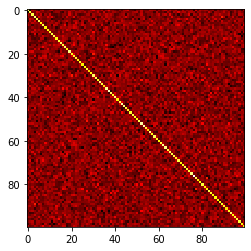

In [14]:
plt.imshow(A.detach().numpy(), cmap='hot', interpolation='nearest')
plt.show()


In [15]:
A[:5,:5]*100000

tensor([[35926.2227, -9299.8750,  3454.7537,   703.4509, -3443.7322],
        [-9299.8750, 33863.3555,  -625.8623, -1771.1759,  6330.3818],
        [ 3454.7537,  -625.8623, 34965.9141, -1898.9648,  2971.2480],
        [  703.4509, -1771.1759, -1898.9648, 37801.3711, -3892.2898],
        [-3443.7322,  6330.3818,  2971.2480, -3892.2898, 35028.7344]],
       grad_fn=<MulBackward0>)

Spec_norm constrain

In [8]:
# define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, momentum=MOMENTUM)


# training loop
train_loss_total = []
for epoch in range(20001):
    train_loss = train(model, optimizer, constrain = "spec_norm")
    train_loss_total.append(train_loss)
    # LOGGING
    if epoch % 5000 == 0:
        print("Epoch: {}/{}  === Train Cost: {}".format(epoch + 1, 20000, train_loss))

    # save model
    # torch.save({'epoch': epoch, 'state_dict': model.state_dict(), 'optimizer' : optimizer.state_dict(),}, args.results_dir + '/model_last.pth')

Epoch: 1/20000  === Train Cost: 0.009126873686909676
Epoch: 5001/20000  === Train Cost: 0.015272129327058792
Epoch: 10001/20000  === Train Cost: 0.004205950070172548
Epoch: 15001/20000  === Train Cost: 0.012573322281241417
Epoch: 20001/20000  === Train Cost: 0.002206307603046298


In [10]:
M = model.M.weight
A = M.T.matmul(M)

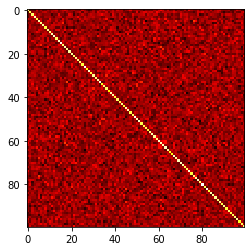

In [11]:
plt.imshow(A.detach().numpy(), cmap='hot', interpolation='nearest')
plt.show()

In [12]:
A[:5,:5]

tensor([[ 0.2631, -0.0361, -0.0339, -0.0428,  0.0283],
        [-0.0361,  0.2484, -0.0085, -0.0006,  0.0086],
        [-0.0339, -0.0085,  0.2611,  0.0375, -0.0102],
        [-0.0428, -0.0006,  0.0375,  0.2962,  0.0167],
        [ 0.0283,  0.0086, -0.0102,  0.0167,  0.2424]],
       grad_fn=<SliceBackward0>)

In [13]:
U, S, Vh = torch.linalg.svd(A, full_matrices=False)
S

tensor([9.9919e-01, 9.8876e-01, 9.0707e-01, 8.9397e-01, 8.5063e-01, 8.1302e-01,
        7.7340e-01, 7.5634e-01, 7.3248e-01, 7.0858e-01, 7.0419e-01, 6.6549e-01,
        6.4641e-01, 6.2371e-01, 6.0035e-01, 5.8116e-01, 5.7654e-01, 5.5254e-01,
        5.1256e-01, 5.0287e-01, 4.9423e-01, 4.8064e-01, 4.7167e-01, 4.6654e-01,
        4.5365e-01, 4.3970e-01, 4.1834e-01, 4.0432e-01, 3.9695e-01, 3.9355e-01,
        3.7868e-01, 3.6188e-01, 3.5793e-01, 3.4424e-01, 3.1799e-01, 3.0253e-01,
        2.8887e-01, 2.8643e-01, 2.7938e-01, 2.7153e-01, 2.4894e-01, 2.4024e-01,
        2.3301e-01, 2.2778e-01, 2.1922e-01, 2.0934e-01, 1.9867e-01, 1.9231e-01,
        1.8874e-01, 1.8378e-01, 1.7738e-01, 1.7320e-01, 1.6896e-01, 1.6033e-01,
        1.4746e-01, 1.4024e-01, 1.3367e-01, 1.2596e-01, 1.1852e-01, 1.1410e-01,
        1.0886e-01, 1.0304e-01, 9.7979e-02, 9.5322e-02, 8.6615e-02, 8.3667e-02,
        7.9010e-02, 7.5851e-02, 7.4784e-02, 6.7727e-02, 6.2022e-02, 5.6110e-02,
        5.3070e-02, 5.1091e-02, 4.6503e-